# COLX 585 Trends in Computational Linguistics
## Model interpretability using representation erasure

### Goal of this tutorial:
- Know the technique of interpreting NLP model using representation erasure
- Apply the technique on a CNN model trained on sentiment analysis task

###  General:
- This notebook was last tested on Python 3.6.4, PyTorch 0.4.0, spacy 2.2.3 (along with the NLP modules for English language, that is, `python -m spacy download en`)
- We analyze the CNN model checkpoint provided by https://github.com/pytorch/captum/blob/master/tutorials/models/imdb-model-cnn.pt trained using the code https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb
- We borrowed the code to load pretrain model and vocab from: https://captum.ai/tutorials/IMDB_TorchText_Interpret

### References
To know more about the above-mentioned concepts, take a look at the following articles:
1. Understanding Neural Networks through Representation Erasure: https://arxiv.org/abs/1612.08220
2. Visualizing and Understanding Neural Models in NLP: https://arxiv.org/abs/1506.01066

## Background

### Model interpretability
Neural network models are successful in many NLP tasks such as text classification, machine translation, question answering and so on. Unfortunately, their superior performance comes at the cost of interpretability. Compared to traditional ML models that optimize on human interpretable features, neural models operate like a black box using vectorial representations (as opposed to human understandable features). 

<img src="images/cnn_text.png" alt="CNN" title="CNN" height="250" width="720" />

Picture courtesy: http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/

[Mystery exist at many levels in neural models](https://arxiv.org/abs/1612.08220):
* At input layers, what does each word vector dimension stand for? 
* What do hidden units in intermediate levels stand for? 
* How does the model combine meaning from different parts of the sentence, filtering the informational wheat from the chaff?
* How is the final decision made at the output layer?

These mysteries make it hard to tell when and why a neural model makes mistakes, namely, to perform error analysis. This difficulty hinders further efforts to correct these mistakes.



### Representation erasure - Motivation
This tutorial will focus on **representation erasure**, a simple yet effective technique to analyze and interpret neural model prediction. The idea is to analyze the effect of erasing pieces of the representation,
to see how such changes affect the decision of a neural model. By analyzing the harm this erasure does,
we can identify important representations that significantly contribute to a model’s decision. By 
analyzing the benefit this erasure introduces, namely, the cases in which the removal of a representation actually improves a model’s decision, we can identify representations that a neural model inappropriately focuses
its attention on, as a form of error analysis.

This erasure can be performed on various levels of representation including:
- input word-vector dimensions
- input words (focus of this tutorial)
- input phrases
- intermediate hidden units

In this tutorial, we will focus only on analyzing the **important words** in a input sentence according to a CNN sentiment classifier. Note that the technique is simple (as we will see in next section) and can be easily adapted to other levels of representation (hidden units, phrases) as well as a wide variety of NLP models/architectures (RNN, LSTM, Transformer). 

### Representation erasure - Examples

Before looking into the theory, let us look at some results of **word level** importance scores taken from the original paper.

First example is a heatmap in sentiment analysis plotting the importance of individual word in positive sentence `one of the greatest family-oriented , fantasy-adventure movies ever .` assigned by three different models (RNN, LSTM, BiLSTM).

<img src="images/positive_sentence.png" alt="erasure" title="Erasure" height="300" width="250" />

As can be seen, all three models attach more importance to words that are indicative of sentiment (e.g.,
 `greatest`) and dampen the influence of other tokens. LSTM-based models generally show a clearer focus on sentiment words than standard RNN models
 
Second example is a heatmap in sentiment analysis plotting the importance of individual word in a negative sentence `the story loses its bite in a last-minute happy ending that 's even less plausible than the rest of the picture .` assigned by three different models (RNN, LSTM, BiLSTM).

<img src="images/negative_sentence.png" alt="erasure" title="Erasure" height="300" width="250" />

### Representation erasure - Theory

* Let $M$ denote the trained neural model. (e.g. M=CNN)
* Let $E$ denote the set of training examples, with a single example $e \in E$ (e.g. $e$ = `one of the greatest family-oriented , fantasy-adventure movies ever .` and $E$ is the sentiment training data)
* Let $c$ be the gold-standard label of $e$ (e.g. $c = 1$ (Positive))
* Let $S(e,c)$ be the probability assigned by model $M$ to the correct label for $e$, which is $c$ and $S(e,c) =  P(L_e = c)$ (e.g. $S(e,c) = 0.95$)
* Let $S(e,c,\neg d)$ be the probability assigned of the correct label for $e$ (which is $c$) by model $M$ if dimension $d$ is erased, that is its value set to 0. (e.g. $S(e,c,\neg d) = 0.6$)
* Importance of dimension $d$ is given by the relative difference between $S(e,c)$ and $S(e,c,\neg d)$: $I(d)= \frac{1}{|E|} \sum_{e \in E} \frac{S(e,c) - S(e,c,\neg d)}{S(e,c)} $

If you want to compute the importance of a word (with its corresponding word embedding, $w$) in a given example $e$,

$I(w)= \frac{S(e,c) - S(e,c,\neg w)}{S(e,c)} $ where $S(e,c,\neg w)$ denote the probability assigned by model for the correct label if values of the word embedding ($w$) are set to 0.

If you want to compute the importance of a word (with its corresponding word embedding, $w$) according to the model in general (no specific example),

$I(w)= \frac{1}{|E|} \sum_{e \in E}  \frac{S(e,c) - S(e,c,\neg w)}{S(e,c)} $
where $E$ denotes the training examples that contains the word corresponding to $w$ 

# Implementation

In this notebook we will do the following:
* Load a pretrained CNN model for sentiment analysis on IMDB dataset
* Make predictions on test samples and interpret those predictions using representation erasure method
* Identify the most important words and least important words according to CNN model

Before we start, let us download the following:
* `imdb-model-cnn.pt` - trained sentiment analysis model on IMDB dataset that we are going to analyze today https://github.com/pytorch/captum/blob/master/tutorials/models/imdb-model-cnn.pt  This model was trained using an open source sentiment analysis tutorials described in: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb
* `data` - IMDB dataset used to train the original CNN model  https://ai.stanford.edu/~amaas/data/sentiment/ (We will use the training examples to identify the general important words)
* `glove.6B.50d.txt` - Pretrained glove word embeddings from http://nlp.stanford.edu/data/glove.6B.zip

Let us first import the required libraries.

In [1]:
# required imports
import torch
import torchtext
import torchtext.data
import torch.nn as nn
import torch.nn.functional as F
import spacy

from torchtext.vocab import Vocab

# load spacy module
nlp = spacy.load('en')

# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Let us now redefine the model in order to be able to load it.

In [2]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        #text = [batch size, sent len]
        embedded = self.embedding(text)

        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)


Let us load trained CNN model and sets the model to `eval` mode.

In [3]:
model = torch.load('models/imdb-model-cnn.pt')
model.eval()
model = model.to(device)
print(model)

CNN(
  (embedding): Embedding(101982, 50, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 50), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 50), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 50), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


/anaconda3/envs/ctrl_transformers/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda3/envs/ctrl_transformers/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda3/envs/ctrl_transformers/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original

Let us load the IMDB data (We will use later to identify general important words according to CNN model.)

In [4]:
# define field to read data
TEXT = torchtext.data.Field(lower=True, tokenize='spacy')
Label = torchtext.data.LabelField(dtype = torch.float)

# read train and test (ignored)
train_full, test_full = torchtext.datasets.IMDB.splits(text_field=TEXT,
                                      label_field=Label,
                                      train='train',
                                      test='test',
                                      path='data/aclImdb')

Let us build the vocabulary (exactly the same way the original author did; id to word mapping (vice-versa) is same) and constraint the words to those that are present in the pretrained glove word embeddings.

In [5]:
# load the glove word embeddings
loaded_vectors = torchtext.vocab.Vectors('data/glove.6B.50d.txt')
# build the vocab for both fields
TEXT.build_vocab(train_full, vectors=loaded_vectors, max_size=len(loaded_vectors.stoi))  
TEXT.vocab.set_vectors(stoi=loaded_vectors.stoi, vectors=loaded_vectors.vectors, dim=loaded_vectors.dim)
Label.build_vocab(train_full)

We have loaded the pretrained model and vocab successfully.

Now, we will move on to analyzing CNN prediction for few sentences.

Let us start with a simple sentence, `it was a fantastic performance !` and the gold sentiment label is 1 (positive). 

In [6]:
sample_sentence = 'it was a fantastic performance !'
print(sample_sentence)

it was a fantastic performance !


Let us tokenize the sentence to token ids. 

In [7]:
token_ids = [TEXT.vocab.stoi[tok.text] for tok in nlp.tokenizer(sample_sentence)]
print(token_ids)

[10, 19, 6, 793, 251, 42]


Let us pad the sentence if the number of tokens is less than minimum number of tokens required in the input (which is 5 - maximum width of the kernel used by the original author).

In [8]:
if len(token_ids) < 5: # where 5 in min_len
    token_ids += [TEXT.vocab.stoi['pad']] * (5 - len(token_ids))
print(token_ids)

[10, 19, 6, 793, 251, 42]


Let us convert the token ids to tensor

In [9]:
token_tensor = torch.tensor(token_ids, device=device).unsqueeze(0)
print(token_tensor)
print(token_tensor.size())

tensor([[ 10,  19,   6, 793, 251,  42]])
torch.Size([1, 6])


Let us make the prediction (probability of the sentence being positive sentiment)

In [10]:
prediction = round(torch.sigmoid(model(token_tensor)).item())
print(prediction) # probability of the sentence being positive sentiment

1


### Now we can define the function that can compute both:
* $S(e,c)$ - the probability assigned by model $M$ to the correct label for $e$, which is $c$ and $S(e,c) =  P(L_e = c)$ and
* $S(e,c,\neg d)$ - the probability assigned to the correct label for $e$ (which is $c$) by model $M$ if dimension $d$ is erased, that is its value set to 0.

Note that $d$ is the word embedding in our case as we are interested in analyzing the model at **word level**.

In [20]:
def S(trained_model, token_tensor, erase_tokenid, gold_label_id):
    '''
    input:
    i) trained_model - trained CNN model on IMDB dataset
    ii) token_tensor - tensor containing token ids for a test sample 'e'
    iii) erase_tokenid - id corresponding to the token to be erased. -1 if no token needs to be erased (useful in computing S(e,c))
    iv) gold_label_id - gold sentiment label for the test sample 'e'
    
    returns:
    probability by model to the gold label. S(e,c) if erase_tokenid == -1 else S(e,c,~d)
    '''
    
    #token_tensor = [1, sent len]  note: batch_size is 1
    embedded = model.embedding(token_tensor)
    #embedded = [batch size, sent len, emb dim]
    
    # check if word embedings corresponding to a token has to be erased
    if erase_tokenid != -1:
        embedded[0, erase_tokenid, :].fill_(0.0)
    #embedded = [batch size, sent len, emb dim]

    #embedded = [batch size, sent len, emb dim]
    embedded = embedded.unsqueeze(1)
    #embedded = [batch size, 1, sent len, emb dim]

    conved = [F.relu(conv(embedded)).squeeze(3) for conv in model.convs]
    #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]

    pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
    #pooled_n = [batch size, n_filters]

    cat = model.dropout(torch.cat(pooled, dim = 1))
    #cat = [batch size, n_filters * len(filter_sizes)]
    
    # compute the probability of the sentence to be positive sentiment
    prob_positive_class =  torch.sigmoid(model.fc(cat)).item()
    
    # compute the probability of the sentence to be negative sentiment
    prob_negative_class = 1.0 - prob_positive_class
    
    # return the probability by model to the gold label
    return prob_positive_class if gold_label_id == 1.0 else prob_negative_class


We've all the important functions defined and now we can compute the importance of individual word in the sample `it was a fantastic performance !` (e) according to:

$I(w)= \frac{S(e,c) - S(e,c,\neg w)}{S(e,c)} $

For our case, we need to compute 6 importance scores:
* $I('it')= \frac{S(e,1) - S(e,1,\neg 'it')}{S(e,1)} $
* $I('was')= \frac{S(e,1) - S(e,1,\neg 'was')}{S(e,1)} $
* $I('a')= \frac{S(e,1) - S(e,1,\neg 'a')}{S(e,1)} $
* $I('fantastic')= \frac{S(e,1) - S(e,1,\neg 'fantastic')}{S(e,1)} $
* $I('performance')= \frac{S(e,1) - S(e,1,\neg 'performance')}{S(e,1)} $
* $I('!')= \frac{S(e,1) - S(e,1,\neg '!')}{S(e,1)} $

Let us compute $S(e,1)$ first

In [43]:
s_e1 = S(model, token_tensor, -1, 1.0) # -1 for not erasing any token and 1.0 is gold sentiment label
print(s_e1)

0.8908191919326782


Now we can compute importance of the word `it` in the sentence according to the CNN model: $I('it')= \frac{S(e,1) - S(e,1,\neg 'it')}{S(e,1)} $

In [44]:
# compute s(e,1,~'it') - probability after erasing the token 'it'
s_e_it = S(model, token_tensor, 0, 1.0) # 0 denotes first token ('it') to be erased
print(s_e_it)

# compute the important I('it')
imp_it = (s_e1 - s_e_it)/s_e1
print(imp_it)


0.8819364905357361
0.009971385301736326


Similarly, you can compute the importance score for rest of the words in the sentence.

Here goes the full-fledged code which exactly does that and plots the heatmap to visualize the importance scores better.

In [45]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def interpret_sentence(sentence, min_len = 5, true_label = 1):
  '''
  input:
  i) sentence - the sample sentence to be analyzed
  ii) min_len - minimum length of the sentence (alternatively, maximum width of the filter used by the orginal author)
  iii) true_label - gold sentiment label for the sample sentence to be analyzed
  returns:
  None (actually the code plots the heatmap and returns nothing)
  '''
  # tokenize sentence
  token_ids = [TEXT.vocab.stoi[tok.text] for tok in nlp.tokenizer(sentence)]
  # pad the sentence if necessary
  if len(token_ids) < 5: # where 5 in min_len
    token_ids += [TEXT.vocab.stoi['pad']] * (5 - len(token_ids))
  
  # convert to tensor
  token_tensor = torch.tensor(token_ids, device=device).unsqueeze(0)
    
  # get prediction
  prediction = round(torch.sigmoid(model(token_tensor)).item())
   
  # get word importance
  tokens, imp_scores = [None], []
  s_ec = S(model, token_tensor, -1, true_label)
  for t_i, token_id in enumerate(token_ids):
    if token_id != TEXT.vocab.stoi['pad']: # we don't need to calculate importance score for pad tokens (seriously?)
      s_e = S(model, token_tensor, t_i, true_label)
      tokens.append(TEXT.vocab.itos[token_id])
      imp_scores.append([((s_ec-s_e)/s_ec)])
  
  # plot the heatmap and other values
  print('sentence = %s'%sentence)
  print('predicted label = %d; gold label = %d'%(prediction, true_label))
  fig, ax = plt.subplots()
  im = ax.imshow(np.array(imp_scores).transpose(), cmap=plt.cm.Blues)
  ax.set_xticklabels(tokens)
  ax.set_yticklabels(['importance'])
  plt.colorbar(im)
  fig.tight_layout()
  plt.show()


sentence = i loved the dark knight rises movie .
predicted label = 1; gold label = 1


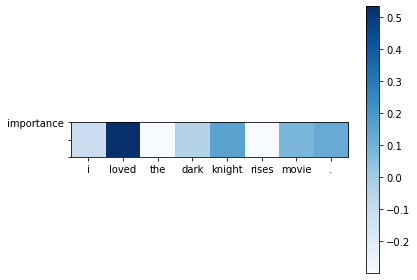

In [46]:
interpret_sentence('i loved the dark knight rises movie .', true_label = 1.0)

Let us try few more examples.

sentence = the plot was predictable and boring .
predicted label = 0; gold label = 0


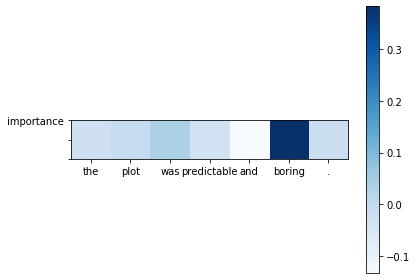

In [47]:
interpret_sentence('the plot was predictable and boring .', true_label = 0.0)

sentence = oh god, my eyes.
predicted label = 0; gold label = 0


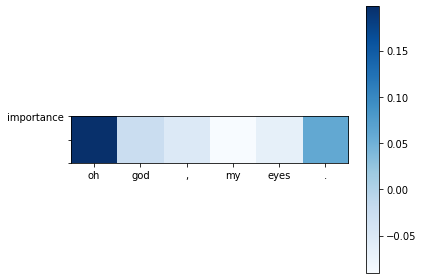

In [48]:
interpret_sentence('oh god, my eyes.', true_label = 0.0)

sentence = it is a disgusting movie !
predicted label = 1; gold label = 0


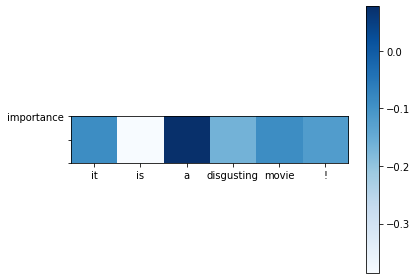

In [49]:
interpret_sentence('it is a disgusting movie !', true_label = 0.0)

Let us now do the last task. We will identify the most important and less important words according to the CNN model. We saw the formula already.

$I(w)= \frac{1}{|E|} \sum_{e \in E}  \frac{S(e,c) - S(e,c,\neg w)}{S(e,c)} $
where $E$ denotes the training examples that contains the word corresponding to $w$ 

In [40]:
from tqdm import tqdm

def compute_word_importance(data_iter, top_k=20):
    '''
    input:
    i) data_iter - iterator over the training examples 
    ii) top_k - number of most and less important words to output
    return:
    i) top_k most important words
    ii) top_k least important words
    '''
    
    # bookkeeping
    word2Sscore = {} # stores word to sum of probability scores
    word2count = {} # stores word to number of examples containing this word
    
    inst_i =0
    # run over training examples
    for batch in data_iter:
      input, label = batch
      s_ec = S(model, input.t(), -1, label) # no erasing
      # run over all the words in the input
      for t_i, token_id in enumerate(input):
        s_e = S(model, input.t(), t_i, label) # erase a token
        token_str = TEXT.vocab.itos[token_id]
        if token_str not in word2Sscore:
          word2Sscore[token_str] = 0
          word2count[token_str] = 0
        word2Sscore[token_str] += (s_ec - s_e)/s_ec
        word2count[token_str] += 1
      inst_i += 1
      if inst_i > 500:
       break
    
    # compute importance score
    word2impscore = {}
    for token_str in word2Sscore:
      word2impscore[token_str] = word2Sscore[token_str] / word2count[token_str]
    
    # sort the words based on importance
    words_to_be_sorted = []
    for word in word2impscore:
      words_to_be_sorted.append((word2impscore[word], word))
    sorted_words = sorted(words_to_be_sorted) # sorts in ascending order in increasing order of importance
    
    # pick the top k as least important  - lower the importance score lesser the importance 
    least_important_words = []
    for word in sorted_words:
      least_important_words.append((word[1], word[0]))
      if len(least_important_words) == top_k:
        break
    
    # sort the words based on decreasing order of importance and pick the top k as most important
    sorted_words.reverse()
    most_important_words = []
    for word in sorted_words:
      most_important_words.append((word[1], word[0]))
      if len(most_important_words) == top_k:
        break
    
    return most_important_words, least_important_words  

# create an iterator over instances (usually done with train instances)
test_subset, _ = test_full.split(split_ratio=0.1)
train_iter = torchtext.data.BucketIterator(dataset=test_subset, batch_size = 1)

# identify the most and least important words
most_important_words, least_important_words = compute_word_importance(train_iter)

Let us print the top 20 most important words.

In [41]:
print('most important words\nno.\tword\tscore')
for i, word_score in enumerate(most_important_words):
  print('%d\t%s\t%.2f'%(i+1, word_score[0], word_score[1]))

most important words
no.	word	score
1	opponent	0.69
2	crawled	0.59
3	repeats	0.54
4	contributed	0.50
5	form.<br	0.49
6	chaney	0.40
7	marcia	0.40
8	vandalism	0.37
9	shabby	0.35
10	/>10	0.35
11	directs	0.35
12	tierney	0.34
13	quigley	0.34
14	stationary	0.32
15	unforgettable	0.31
16	linnea	0.31
17	gripping	0.30
18	ginger	0.30
19	lon	0.29
20	10(dir	0.29


Let us print the top 20 least important words.

In [42]:
print('least important words\nno.\tword\tscore')
for i, word_score in enumerate(least_important_words):
  print('%d\t%s\t%.2f'%(i+1, word_score[0], word_score[1]))

least important words
no.	word	score
1	regis	-34.31
2	erika	-15.15
3	eleniak	-11.20
4	aircraft	-9.21
5	blake	-6.20
6	toomey	-4.63
7	abc	-2.77
8	florida	-2.44
9	schindler	-2.29
10	bowers	-2.14
11	private	-2.01
12	twin	-1.99
13	annoyance	-1.97
14	stanwick	-1.88
15	9	-1.85
16	/>myrna	-1.81
17	springer	-1.81
18	upright	-1.66
19	miscast	-1.58
20	unlikeable	-1.51


That's it!